## Load the fama french dataset

In [1]:
import sys
sys.path.append('../src')

from data_loader import load_sector_data, get_seasonal_returns, calculate_sector_ratio

from timeseries_analysis import (
    reshape_to_timeseries,
    calculate_sp500_returns_ts,
    calculate_smga_returns_ts,
    calculate_sector_rotation_returns_ts,
    filter_period,
)

from fama_french_analysis import (
    run_fama_french_regression,
    print_regression_summary,
    plot_regression_diagnostics,
    plot_factor_loadings,
    plot_alpha_comparison,
    plot_rolling_alpha,
)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import pandas as pd

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

print("✓ Setup complete!")

✓ Setup complete!


## load up fama factors for regression

In [2]:
# loading data and converting into reusable ff factors regression input

# Load the data
file_path = '../data/Seasonal S&P Data as of 11.13.2025 - Abhi.xlsx'
factor_series = {}
factor_skiprows = [(1, "Mkt-RF"), (59, "SMB"), (117, "HML"), (175, "rf")]
for skiprows, factor in factor_skiprows:
    df_monthly = load_sector_data(file_path, "SMB_HML", skiprows, numrows=56)
    ts = reshape_to_timeseries(df_monthly).sort_index()
    ts = pd.to_numeric(ts, errors="coerce")  # ensure numeric
    ts.name = factor
    factor_series[factor] = ts
factors_df = pd.concat(factor_series.values(), axis=1)
factors_df.index.name = "Date"

display(factors_df.head())


,Mkt-RF,SMB,HML,rf
Date,,,,
1970-01-01,-8.100,2.910,3.170,0.600
1970-02-01,5.140,-2.390,3.690,0.620
1970-03-01,-1.060,-2.310,4.080,0.570
1970-04-01,-10.990,-6.140,6.140,0.500
1970-05-01,-6.900,-4.610,3.320,0.530


## load up datasets we want to run regressions on

In [3]:
df_sp500 = load_sector_data(file_path, 'S&P500')
df_tbills = load_sector_data(file_path, 'RF')
df_cyclical = load_sector_data(file_path, 'Discretionary')
df_defense = load_sector_data(file_path, 'Staples')

print("SP 500 data:")
print(f"  Years: {df_sp500.index.min()} - {df_sp500.index.max()}")
print(f"  Shape: {df_sp500.shape}")

print("\nTbills data:")
print(f"  Years: {df_tbills.index.min()} - {df_tbills.index.max()}")
print(f"  Shape: {df_tbills.shape}")


sp500_excess = calculate_sp500_returns_ts(df_sp500, df_tbills)
sp500_excess = filter_period(sp500_excess, start_year=1993, end_year=2025)
print(f"\nS&P 500 excess returns calculated")
print(f"Total observations: {len(sp500_excess)}")
print(f"Date range: {sp500_excess.index.min()} to {sp500_excess.index.max()}")

smga_excess = calculate_smga_returns_ts(df_sp500, df_tbills)
smga_excess = filter_period(smga_excess, start_year=1993, end_year=2025)
print(f"\nSMGA excess returns calculated")
print(f"Total observations: {len(smga_excess)}")
print(f"Date range: {smga_excess.index.min()} to {smga_excess.index.max()}")


rotation_returns = calculate_sector_rotation_returns_ts(df_cyclical, df_defense, df_tbills)
rotation_returns = filter_period(rotation_returns, start_year=1993, end_year=2025)
print(f"Sector rotation returns calculated")
print(f"Total observations: {len(rotation_returns)}")
print(f"Date range: {rotation_returns.index.min()} to {rotation_returns.index.max()}")


SP 500 data:
  Years: 1970 - 2025
  Shape: (56, 12)

Tbills data:
  Years: 1970 - 2025
  Shape: (56, 12)

S&P 500 excess returns calculated
Total observations: 394
Date range: 1993-01-01 00:00:00 to 2025-10-01 00:00:00

SMGA excess returns calculated
Total observations: 394
Date range: 1993-01-01 00:00:00 to 2025-10-01 00:00:00
Sector rotation returns calculated
Total observations: 394
Date range: 1993-01-01 00:00:00 to 2025-10-01 00:00:00


## Run fama regression

In [4]:
# sp500 regression
results_sp500 = run_fama_french_regression(sp500_excess["excess"], ff_factors=factors_df)
print("SP500 regression results")
print_regression_summary(results_sp500, "S&P500")

# smga regression
results_smga = run_fama_french_regression(smga_excess["excess"], ff_factors=factors_df)
print("\nSMGA regression results")
print_regression_summary(results_smga, "SMGA")

# smga regression
results_rotation = run_fama_french_regression(rotation_returns["excess"], ff_factors=factors_df)
print("\nRotation regression results")
print_regression_summary(results_rotation, "Rotation")



SP500 regression results
FAMA-FRENCH REGRESSION RESULTS: S&P500

Alpha (Monthly):      -0.1508%  (p=0.0000)
Alpha (Annual):       -1.8093%
Significance:         ***

Factor Loadings:
  Market (Beta):       0.9884  (p=0.0000)
  SMB (Size):         -0.1787  (p=0.0000)
  HML (Value):         0.0294  (p=0.0000)

Model Fit:
  R-squared:           0.9924
  Adj. R-squared:      0.9923
  Observations:           393


SMGA regression results
FAMA-FRENCH REGRESSION RESULTS: SMGA

Alpha (Monthly):       0.0517%  (p=0.6385)
Alpha (Annual):        0.6204%
Significance:        

Factor Loadings:
  Market (Beta):       0.4852  (p=0.0000)
  SMB (Size):         -0.1170  (p=0.0012)
  HML (Value):         0.0664  (p=0.0476)

Model Fit:
  R-squared:           0.4864
  Adj. R-squared:      0.4825
  Observations:           393


Rotation regression results
FAMA-FRENCH REGRESSION RESULTS: Rotation

Alpha (Monthly):       0.1210%  (p=0.4239)
Alpha (Annual):        1.4517%
Significance:        

Factor Loading

## Plot regression

S&P500 plots


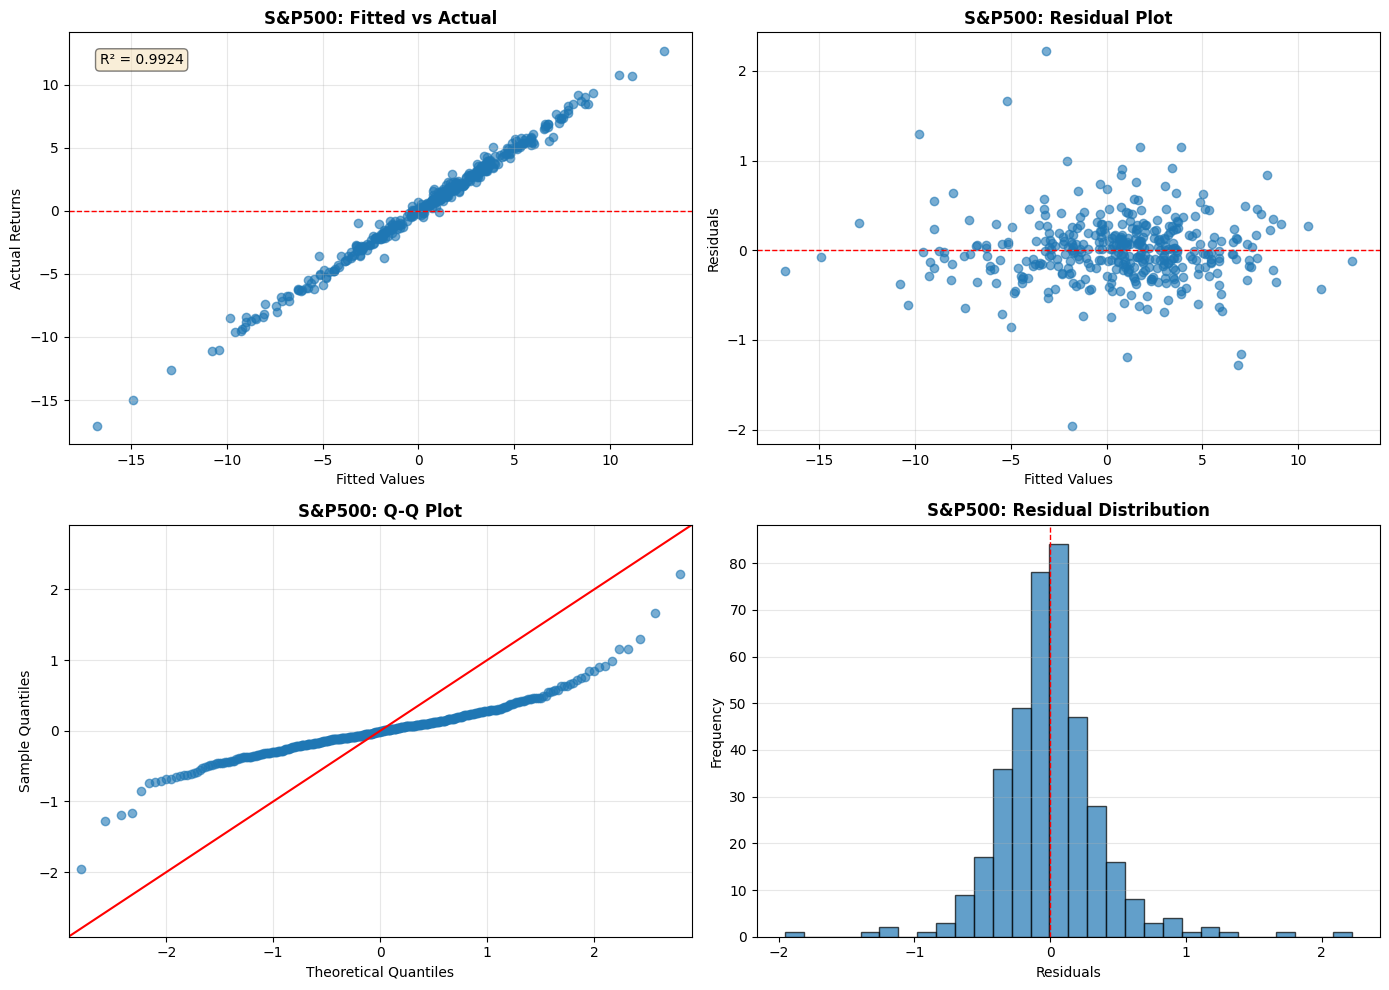

SMGA plots


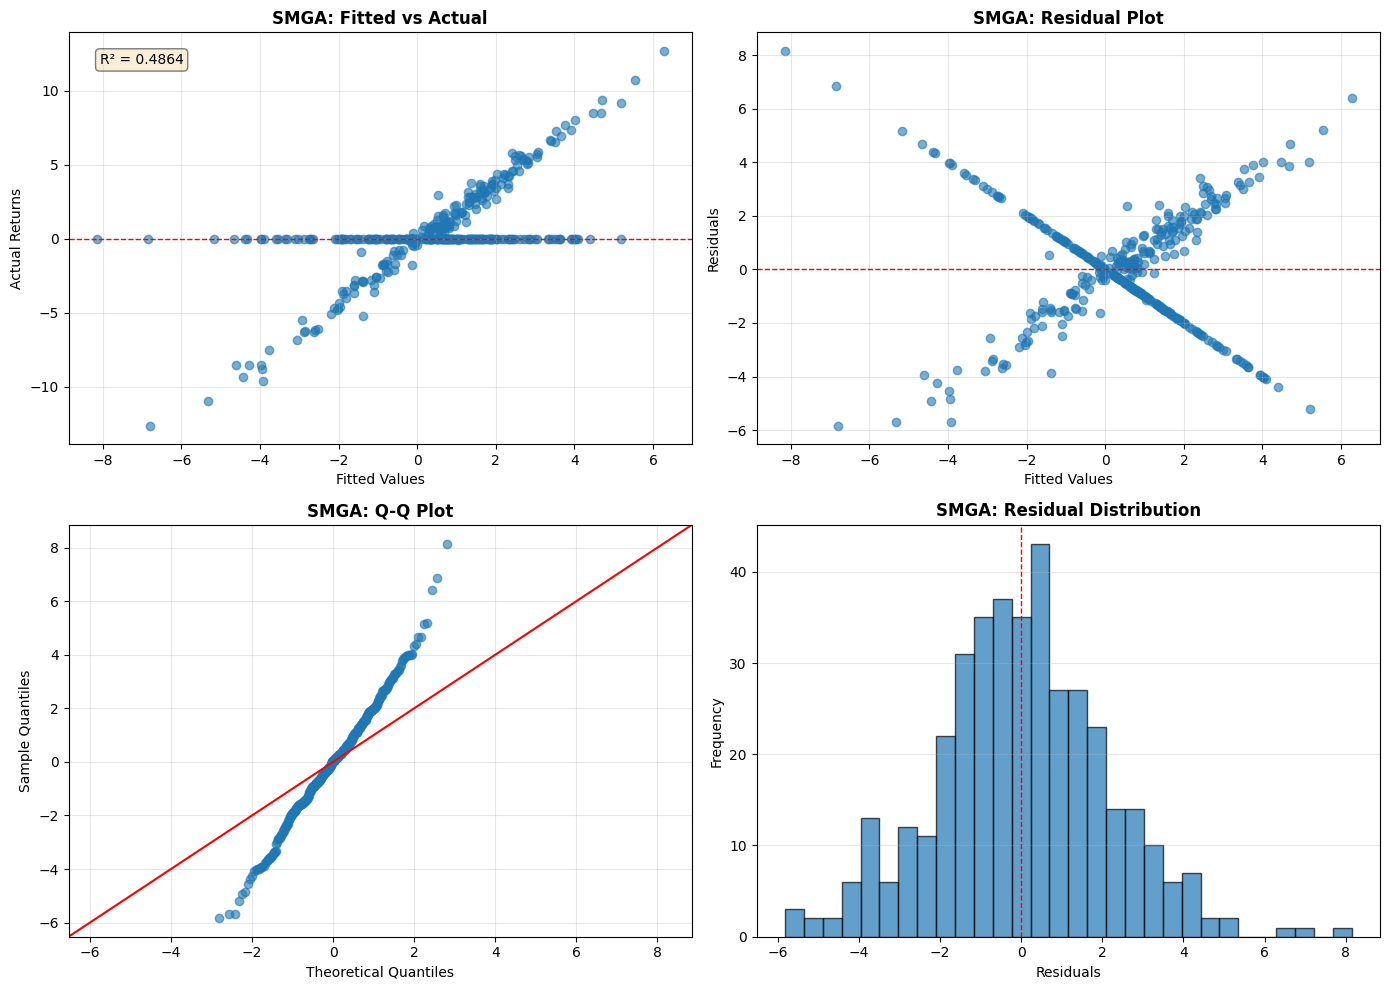

Rotation plots


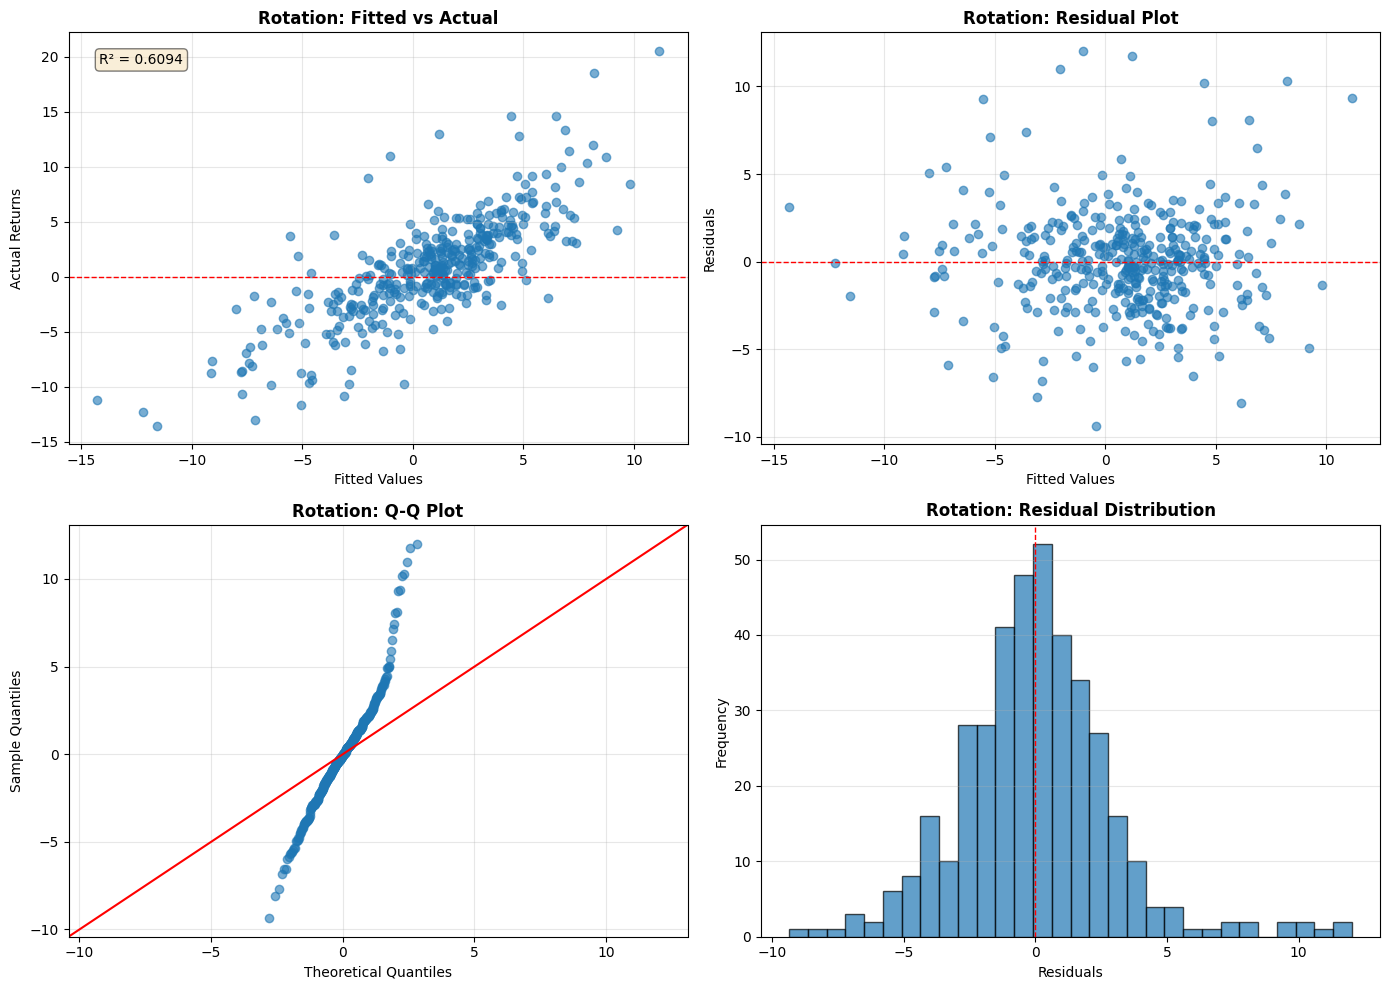

In [5]:
print("========================")
print("S&P500 plots")
print("========================")
plot_regression_diagnostics(sp500_excess, results_sp500, "S&P500")

print("========================")
print("SMGA plots")
print("========================")
plot_regression_diagnostics(smga_excess, results_smga, "SMGA")

print("========================")
print("Rotation plots")
print("========================")
plot_regression_diagnostics(rotation_returns, results_rotation, "Rotation")

## Rolling window alphas

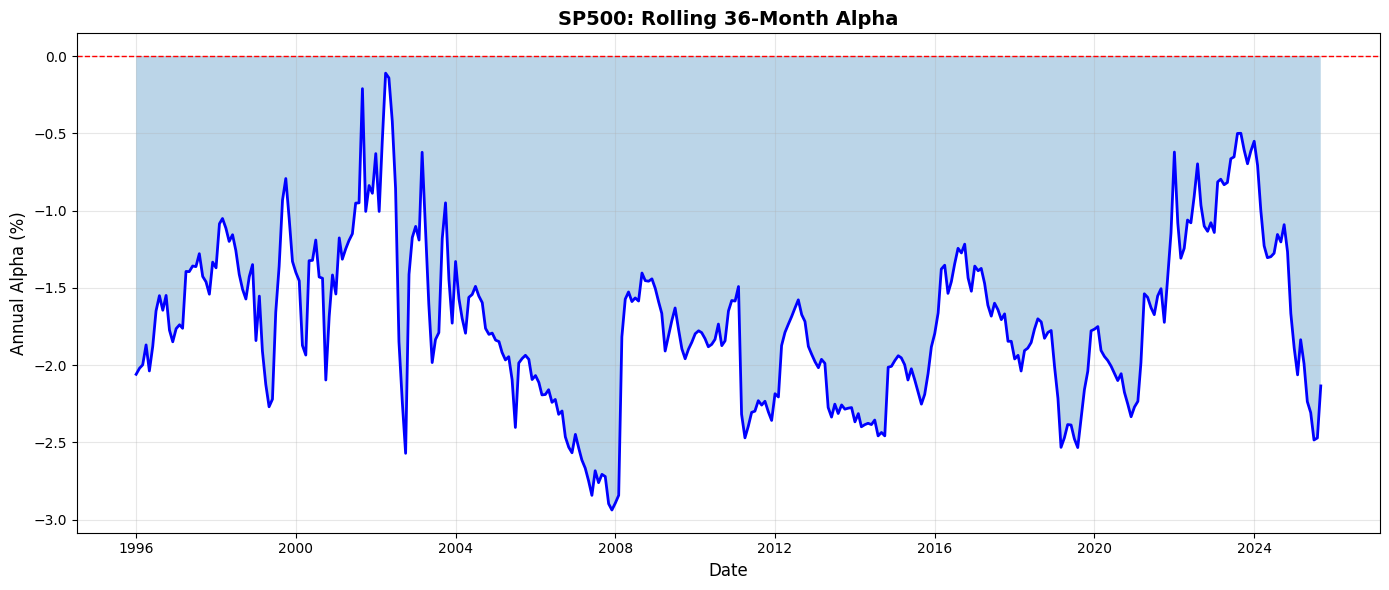

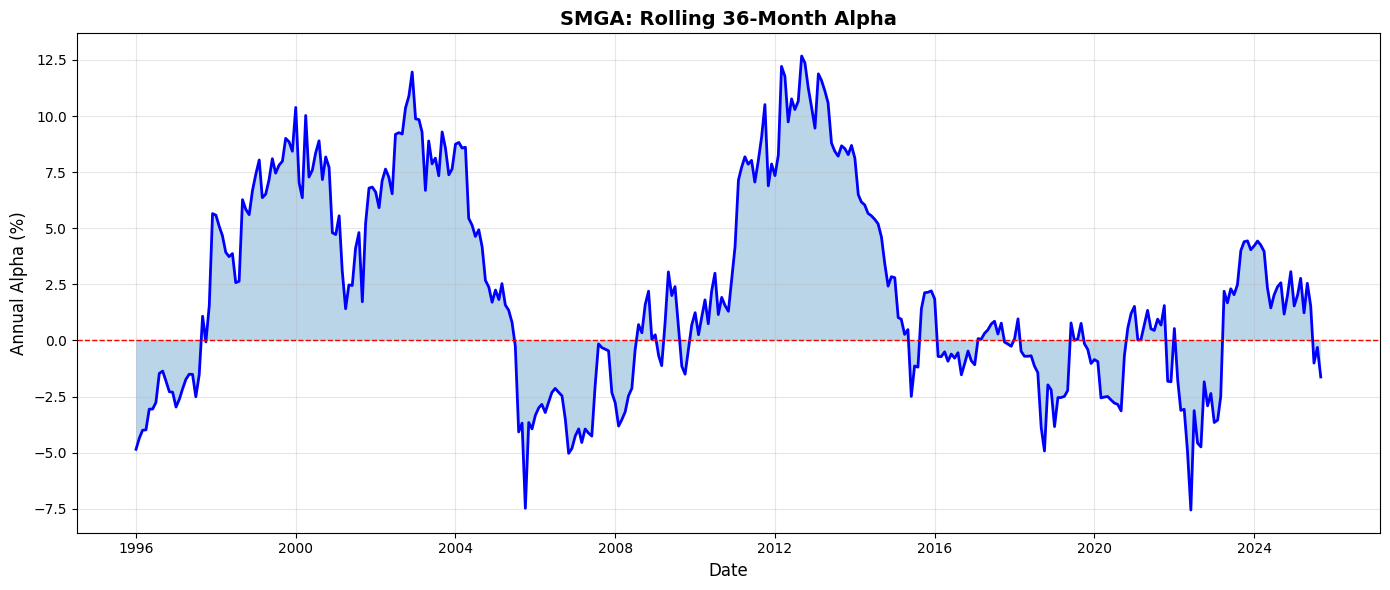

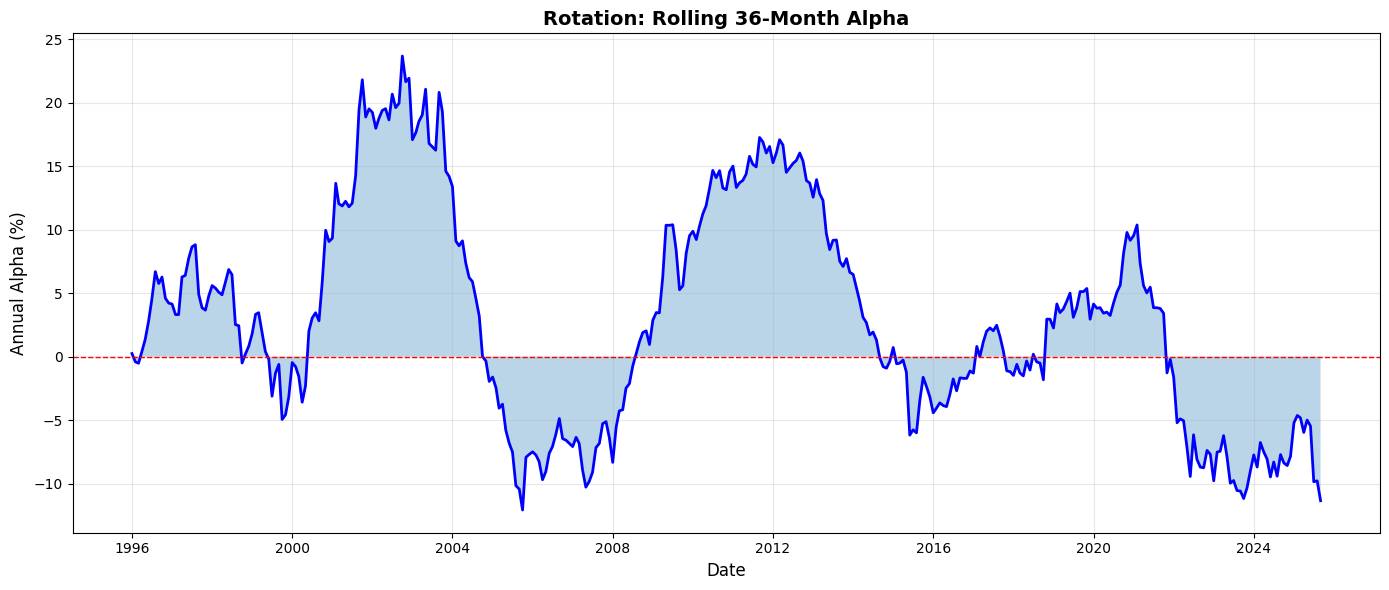

In [6]:
strategies = { 
    "SP500": sp500_excess["excess"],
    "SMGA": smga_excess["excess"],
    "Rotation": rotation_returns["excess"],
}

for strategy, returns in strategies.items():
    plot_rolling_alpha(returns, factors_df, strategy_name=strategy)